In [1]:
"""
Copyright 2021 Aonghus McGovern

This file is part of Music_Image_Matcher_Notebooks_And_Writeup.

Music_Image_Matcher_Notebooks_And_Writeup is free software: you can redistribute it and/or modify it under the terms of the 
GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) 
any later version.

Music_Image_Matcher_Notebooks_And_Writeup is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; 
without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License 
for more details.

You should have received a copy of the GNU General Public License along with Music_Image_Matcher_Notebooks_And_Writeup.  
If not, see <https://www.gnu.org/licenses/>.
"""

'\nCopyright 2021 Aonghus McGovern\n\nThis file is part of Music_Image_Matcher_Notebooks_And_Writeup.\n\nMusic_Image_Matcher_Notebooks_And_Writeup is free software: you can redistribute it and/or modify it under the terms of the \nGNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) \nany later version.\n\nMusic_Image_Matcher_Notebooks_And_Writeup is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; \nwithout even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License \nfor more details.\n\nYou should have received a copy of the GNU General Public License along with Music_Image_Matcher_Notebooks_And_Writeup.  \nIf not, see <https://www.gnu.org/licenses/>.\n'

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the Oramas data
oramas_data = pd.read_csv('oramas_data_with_names.csv')

In [4]:
# Use the same code as in the 'BiasTesting.ipynb'

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_content_matrix(target): 

    target = target.detach()
    # PCA expects a 2d array so we have to reshape
    reshaped = torch.reshape(target, (128, 12544))
                
    pca = PCA(n_components=50)
    pca.fit(reshaped)

    reduced = pca.fit_transform(reshaped)

    return reduced
    
def get_style_matrix(target_feature):
    target = gram_matrix(target_feature).detach()
    
    pca = PCA(n_components=15)
    pca.fit(target)
                
    reduced = pca.fit_transform(target)
    
    return reduced
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def get_image(image_path):
    transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    image = Image.open(open(image_path, 'rb'))
    if image.mode == 'RGB':
        try:
            return transform(image)
        except:
            return None
    else:
        return None

def get_style_model_and_losses(style_img, content_img, cnn = models.vgg19(pretrained=True).features.to(device).eval(), 
                               normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device),
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device),  content_layers=['conv_4'],  
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_matrices = list()
    style_matrices = list()

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_matrices.append(get_content_matrix(target))
            

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_matrices.append(get_style_matrix(target_feature))
            
    return style_matrices, content_matrices
    
def get_closest(image, comparison_album_indexes, comparison_content_matrices, comparison_style_matrices,
               number_matches):
    
    style_matrices, content_matrices = get_style_model_and_losses(image, image)
    test_content_matrix = [np.reshape(content_matrices, (6400,))]
    test_style_matrix = [np.reshape(np.concatenate(style_matrices), (9600,))]

    content_pairwise_distances = pairwise_distances(test_content_matrix, comparison_content_matrices)
    
    style_pairwise_distances = pairwise_distances(test_style_matrix, comparison_style_matrices)
    totals = content_pairwise_distances + (1000000 * style_pairwise_distances)
    
    distances = totals[0]
    sorted_order = np.argsort(distances)

    count = 0
    matched_images = list()
    for i in sorted_order:
        album_index = comparison_album_indexes[i]
        
        row = oramas_data[oramas_data['album_index'] == album_index]
        
        # Return the dataframe index so we can load the image and the song information
        matched_images.append((row.index[0], (row['artist_name'].values[0], 
                              row['album_name'].values[0])))  
        count += 1
        if count == number_matches:
            break
            
    return matched_images

In [7]:
# The all_content_matrices_50_pca and all_style_matrices_15_pca files can be
# downloaded from here: https://drive.google.com/drive/folders/1arJij8GU-2JoTa2i9t5_qJ4XL63i2WNG?usp=sharing

In [8]:
# Load the following for the comparison images:
    # Content matrices
    # Style matrices
    # Album indexes
# All of these lists use the same indexing e.g. comparison_album_indexes[0] corresponds to comparison_content_matrices[0]
# which corresponds to comparison_style_matrices[0]
comparison_content_matrices = pickle.load(open('all_content_matrices_50_pca', 'rb'))
comparison_style_matrices = pickle.load(open('all_style_matrices_15_pca', 'rb'))
comparison_album_indexes = pickle.load(open('all_album_indexes', 'rb'))

TEST


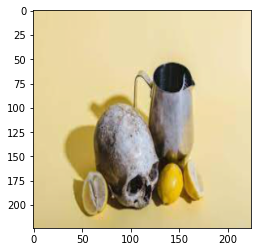

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


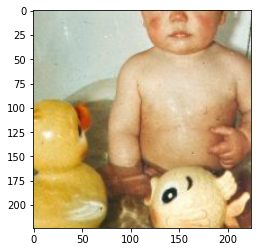

Artist name, Album name
(('Lovvers', 'OCD Go Go Go Girls'),)


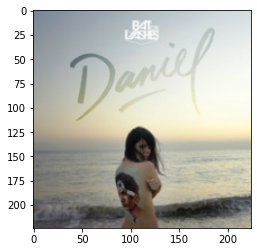

Artist name, Album name
(('Bat For Lashes', 'Daniel (Duke Dumont Remix)'),)


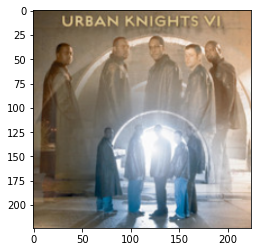

Artist name, Album name
(('Urban Knights', 'Urban Knights VI'),)


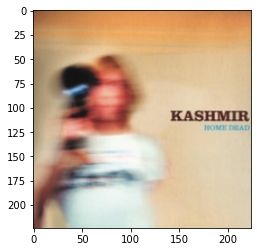

Artist name, Album name
(('Kashmir', 'Home Dead'),)


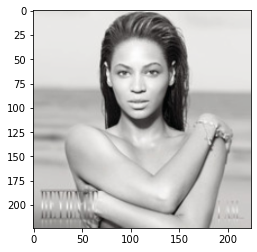

Artist name, Album name
(('Beyoncé', 'I AM...SASHA FIERCE'),)


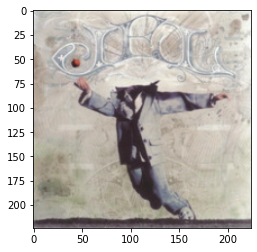

Artist name, Album name
(('Jel', 'Soft Money'),)


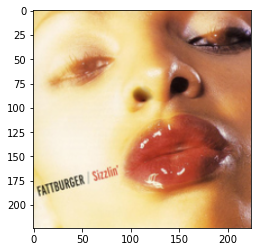

Artist name, Album name
(('Fattburger', "Sizzlin'"),)


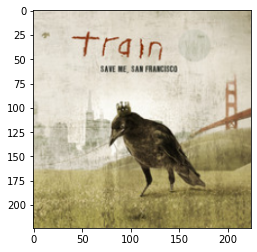

Artist name, Album name
(('Train', 'Save Me_ San Francisco'),)


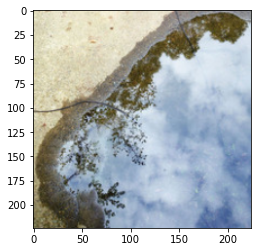

Artist name, Album name
(('9mm Parabellum Bullet', 'The World e.p.'),)


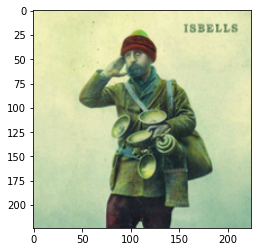

Artist name, Album name
(('Isbells', 'Isbells'),)
TEST


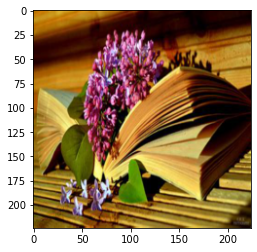

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


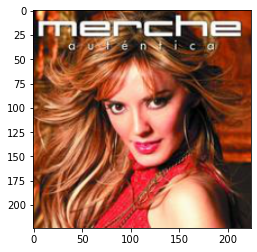

Artist name, Album name
(('Merche', 'Autentica'),)


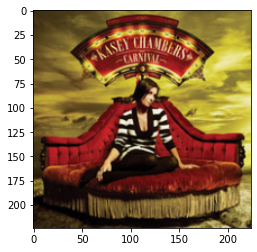

Artist name, Album name
(('Kasey Chambers', 'Carnival'),)


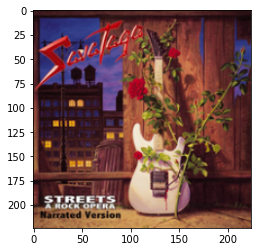

Artist name, Album name
(('Savatage', 'Still The Orchestra Plays - Greatest Hits Volume 1 & 2'),)


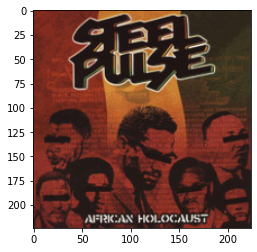

Artist name, Album name
(('Steel Pulse', 'African Holocaust'),)


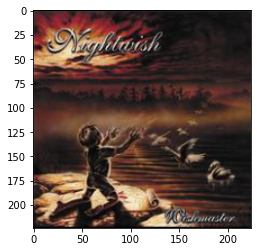

Artist name, Album name
(('Nightwish', 'Wishmaster'),)


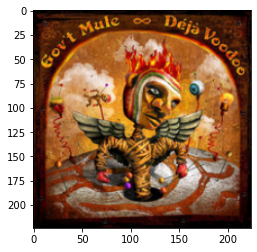

Artist name, Album name
(("Gov't Mule", 'Deja Voodoo'),)


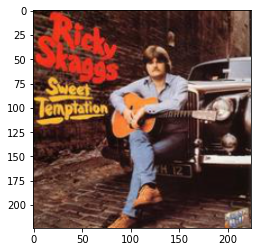

Artist name, Album name
(('Ricky Skaggs', 'Sweet Temptation'),)


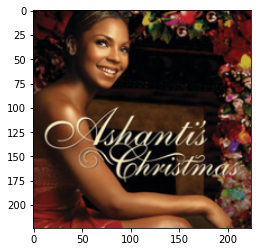

Artist name, Album name
(('Ashanti', "Ashanti's Christmas"),)


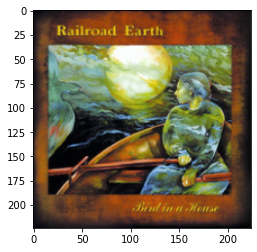

Artist name, Album name
(('Railroad Earth', 'Bird In A House'),)


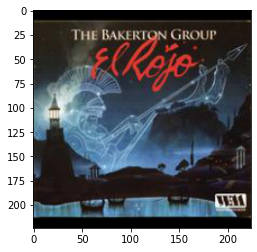

Artist name, Album name
(('The Bakerton Group', 'El Rojo'),)
TEST


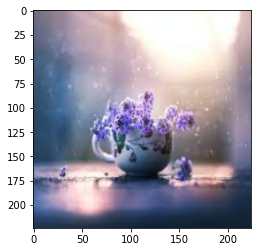

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


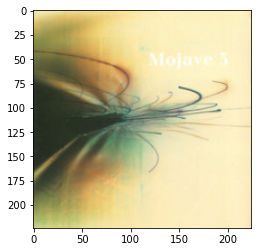

Artist name, Album name
(('Mojave 3', 'Ask Me Tomorrow'),)


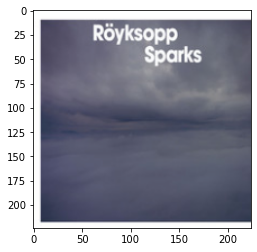

Artist name, Album name
(('Röyksopp', 'Sparks'),)


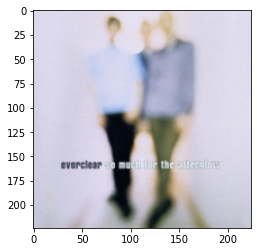

Artist name, Album name
(('Everclear', 'So Much For The Afterglow'),)


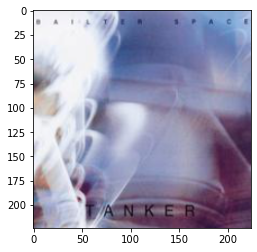

Artist name, Album name
(('Bailter Space', 'Tanker / Nelsh'),)


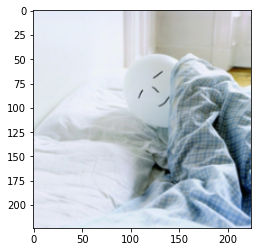

Artist name, Album name
(('Malcolm Middleton', "We're All Going To Die"),)


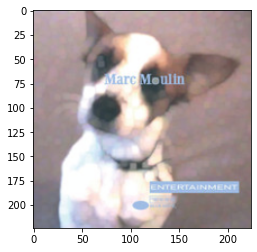

Artist name, Album name
(('Marc Moulin', 'Entertainment'),)


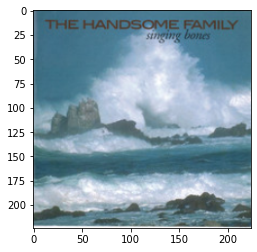

Artist name, Album name
(('The Handsome Family', 'Singing Bones'),)


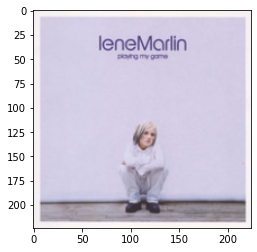

Artist name, Album name
(('Lene Marlin', 'Playing My Game'),)


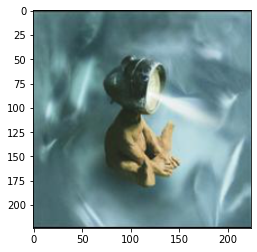

Artist name, Album name
(('Ornatos Violeta', 'O Monstro Precisa De Amigos'),)


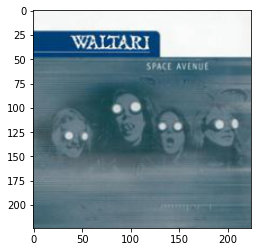

Artist name, Album name
(('Waltari', 'Space Avenue'),)
TEST


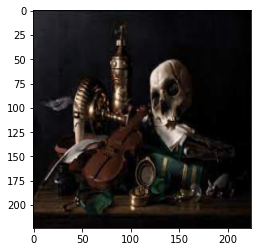

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


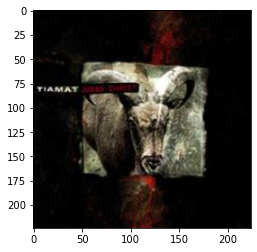

Artist name, Album name
(('Tiamat', 'Judas Chist'),)


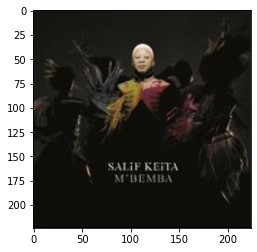

Artist name, Album name
(('Salif Keita / Buju Banton', "M'Bemba"),)


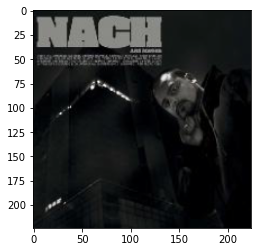

Artist name, Album name
(('Nach', 'Ars Magna / Miradas'),)


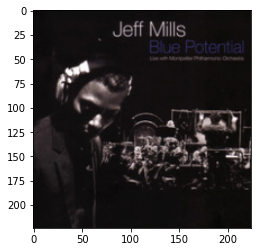

Artist name, Album name
(('Jeff Mills', 'Blue Potential - Live with Montpelier Philharmonic Orchestra'),)


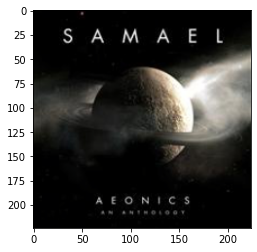

Artist name, Album name
(('Samael', 'Aeonics - An Anthology'),)


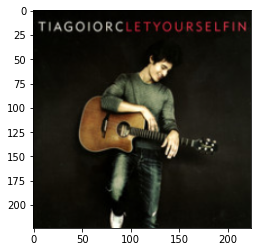

Artist name, Album name
(('Tiago Iorc', 'Let Yourself In'),)


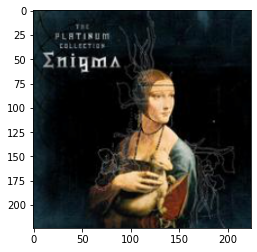

Artist name, Album name
(('Enigma', 'The Platinum Collection'),)


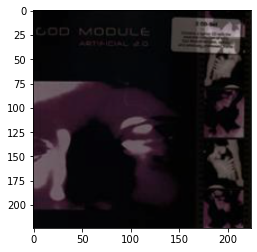

Artist name, Album name
(('God Module', 'Artificial 2.0'),)


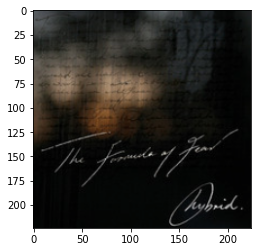

Artist name, Album name
(('Hybrid', 'Formula Of Fear'),)


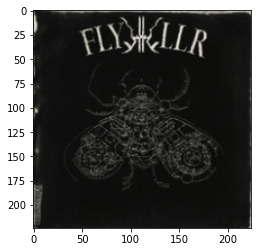

Artist name, Album name
(('Flykkiller', 'Experiments In Violent Light'),)
TEST


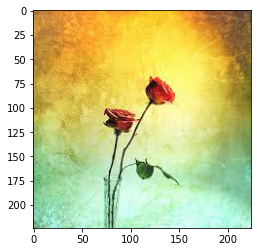

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


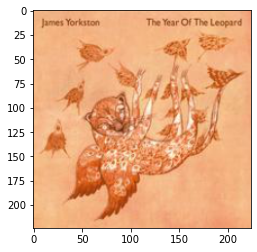

Artist name, Album name
(('James Yorkston', 'The Year Of The Leopard'),)


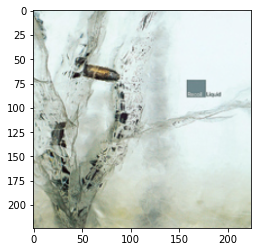

Artist name, Album name
(('Recoil', 'Liquid (Bonus Tracks)'),)


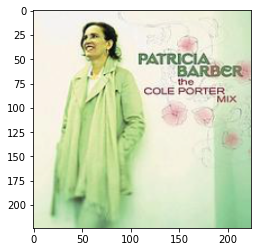

Artist name, Album name
(('Patricia Barber', 'The Cole Porter Mix'),)


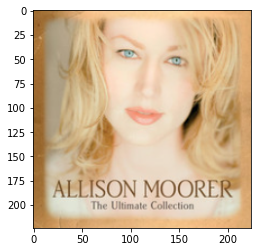

Artist name, Album name
(('Allison Moorer', 'The Hardest Part'),)


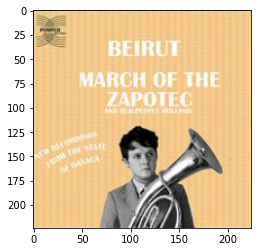

Artist name, Album name
(('Beirut', 'March of the Zapotec and Realpeople Holland'),)


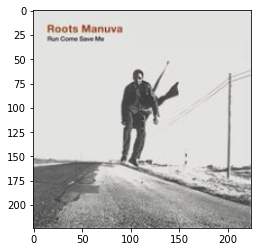

Artist name, Album name
(('Roots Manuva', 'Run Come Save Me'),)


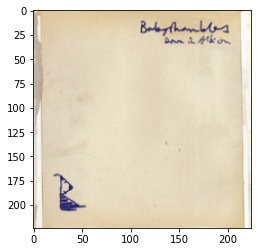

Artist name, Album name
(('Babyshambles', 'Down In Albion'),)


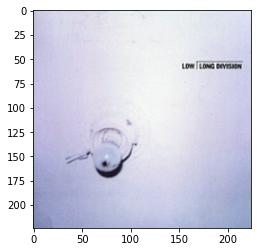

Artist name, Album name
(('Low', 'Long Division'),)


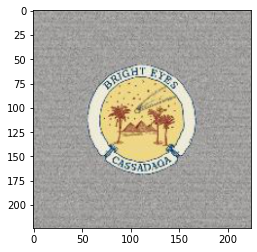

Artist name, Album name
(('Bright Eyes', 'Cassadaga'),)


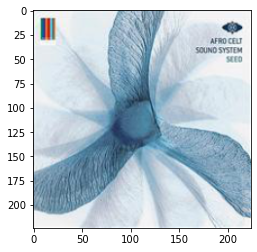

Artist name, Album name
(('Afro Celts', 'Seed'),)
TEST


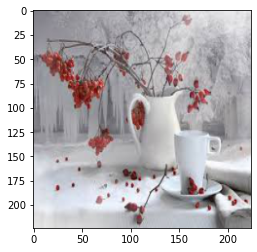

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


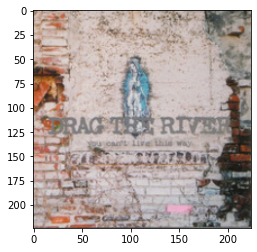

Artist name, Album name
(('Drag The River', "You Can't Live This Way"),)


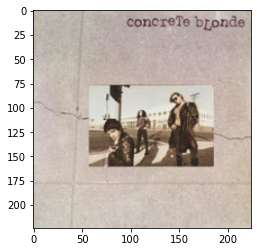

Artist name, Album name
(('Concrete Blonde', 'Concrete Blonde'),)


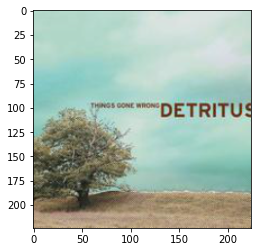

Artist name, Album name
(('Detritus', 'Things Gone Wrong'),)


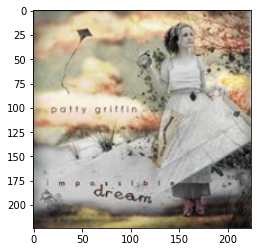

Artist name, Album name
(('Patty Griffin', 'Impossible Dream'),)


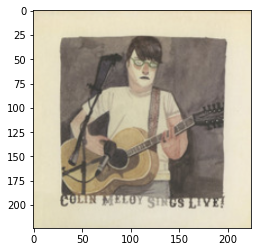

Artist name, Album name
(('Colin Meloy', 'Sings Live'),)


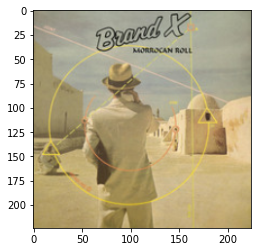

Artist name, Album name
(('Brand X', 'Morrocan Roll'),)


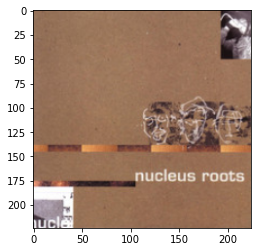

Artist name, Album name
(('Nucleus Roots', 'Nucleus Roots'),)


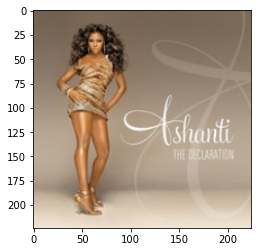

Artist name, Album name
(('Ashanti', 'The Declaration'),)


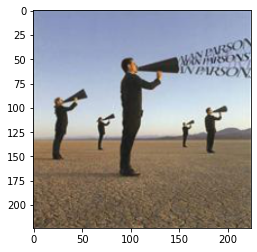

Artist name, Album name
(('Alan Parsons', 'Live (db)'),)


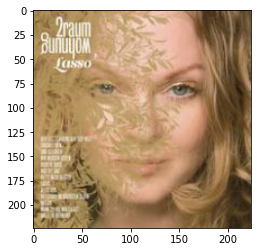

Artist name, Album name
(('2raumwohnung', 'Lasso'),)
TEST


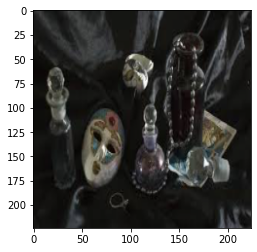

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


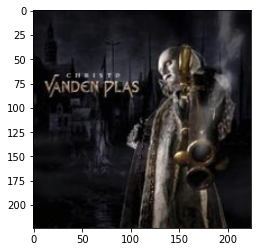

Artist name, Album name
(('Vanden Plas', 'Christ 0'),)


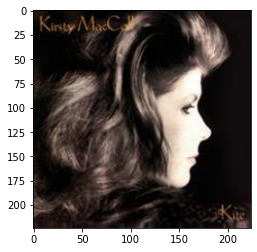

Artist name, Album name
(('Kirsty MacColl', 'Kite'),)


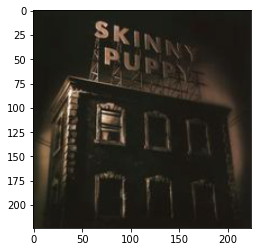

Artist name, Album name
(('Skinny Puppy', 'The Process'),)


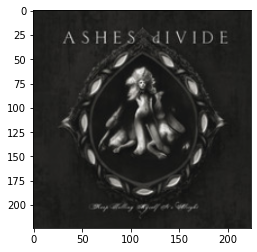

Artist name, Album name
(('ASHES dIVIDE', "Keep Telling Myself It's Alright"),)


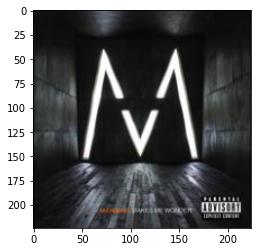

Artist name, Album name
(('Maroon 5', 'Wake Up Call'),)


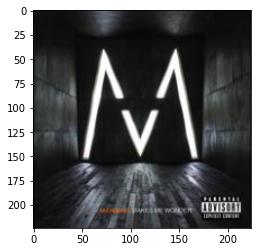

Artist name, Album name
(('Maroon 5', 'Makes Me Wonder'),)


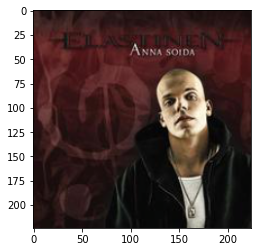

Artist name, Album name
(('Elastinen', 'Anna soida'),)


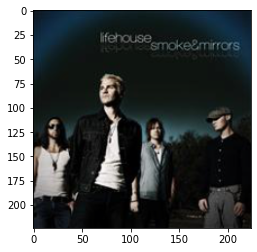

Artist name, Album name
(('Lifehouse', 'Smoke & Mirrors'),)


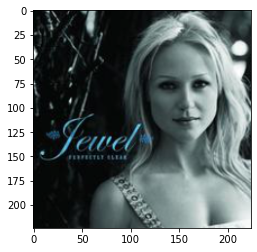

Artist name, Album name
(('Jewel', 'Perfectly Clear'),)


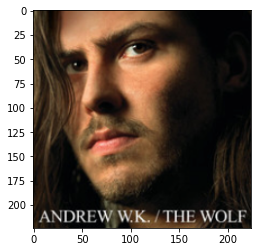

Artist name, Album name
(('Andrew W.K.', 'The Wolf'),)
TEST


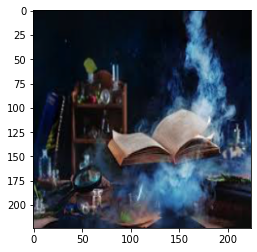

C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\amcgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


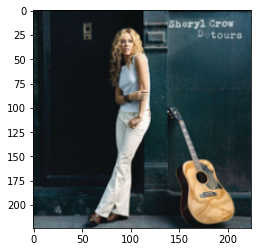

Artist name, Album name
(('Sheryl Crow', 'Detours'),)


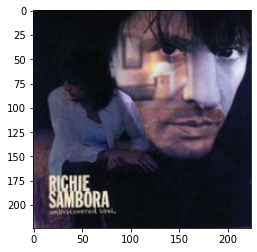

Artist name, Album name
(('Richie Sambora', 'Undiscovered Soul'),)


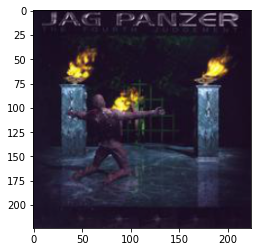

Artist name, Album name
(('Jag Panzer', 'The Fourth Judgement'),)


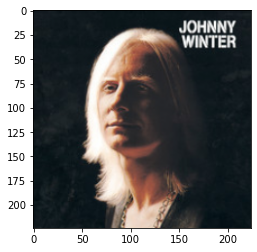

Artist name, Album name
(('Johnny Winter', 'Johnny Winter'),)


KeyboardInterrupt: 

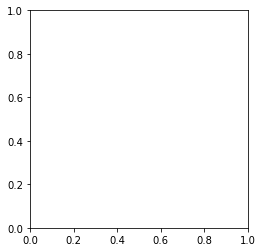

In [9]:
image_folder = 'Photographs/still_life/'
images_to_match = 'Images/'
count = 0
for img in os.listdir(image_folder):
    
    image = get_image('%s/%s' % (image_folder, img))
    print('TEST')
    imshow(image)
    image = torch.unsqueeze(image, 0)
    
    for match in get_closest(image, comparison_album_indexes, comparison_content_matrices, comparison_style_matrices, 10):
        
        matched_image = get_image('%s/%s.jpg' % (images_to_match, match[0]))
        imshow(matched_image)
        print('Artist name, Album name')
        print(match[1:])
    